# Plot Trajectories

Plotting various trajecories to demonstrate the difference between PID, RL trained in 1 direction, and RL trained on 4 directions of wind. See other notebooks, such as `Demo.ipynb` for more details about some of these functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax

### Loading Agents

In [2]:
env_selector = OctorotorEnvSelector()

In [3]:
env_selector = OctorotorEnvSelector()
# pid_sl_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}
# pid_sl_agent = PIDAgent()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000}
pid_agent = PIDAgent()

study, naive_agent, naive_params = get_agent('naive')
naive_params['steps_u'] = 50
naive_params['bounding_rect_length']=1000

study, oracle_agent, oracle_params = get_agent('oracle')
oracle_params['steps_u'] = 50
oracle_params['bounding_rect_length']=1000

study, lstm_agent, lstm_params = get_agent('windlstm') # maybe use this agent instead, it seems better
lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

[I 2023-09-30 00:24:41,438] Using an existing study with name 'naive' instead of creating a new one.
[I 2023-09-30 00:24:42,983] Using an existing study with name 'oracle' instead of creating a new one.
[I 2023-09-30 00:24:43,027] Using an existing study with name 'windlstm' instead of creating a new one.


In [4]:
all_agents = [pid_agent, lstm_agent, pid_agent, lstm_agent]
all_params = [pid_params, lstm_params, pid_params, lstm_params]
names = ['PID Tarot', 'RL-DR Tarot', 'PID DJI', 'RL-DR DJI']
env_types = [ 'sliding', 'lstm', 'dji_sliding', 'dji_lstm']
uses_dji = [False, False, True, True]

In [5]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [6]:
# Evaluates all saved agents with their params on a wind range
def evaluate_agents(agents, params, wind_range, types, uses_dji):
    logs = []
    
    for agent, param, env_type, is_dji in tqdm(zip(agents, params, types, uses_dji), total=len(agents)):
        
        env = env_selector.get_env(env_type, param, wind_range, nasa_wp, start_alt=30, has_turbulence=True)
            
        done = False
        state = env.reset()
        state = np.array(state, dtype=np.float32)
        log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                          other_vars=('reward',))

        wps = []
        while not done:
            action = agent.predict(state, deterministic=True)[0] 
            state, reward, done, info = env.step(action)
            state = np.array(state, dtype=np.float32)
            log.log(reward=reward)
            wps.append(env.base_env.next_waypt)
        
        log.done_logging()
        logs.append(log)

    return logs, wps

## Real Trajectory Evaluation

### 10 m/s North

In [7]:
logs, wps = evaluate_agents(all_agents, all_params, [(0,0), (10,10), (0,0)], env_types, uses_dji)

 25%|██████████████████▊                                                        | 1/4 [00:11<00:33, 11.02s/it]/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.86s/it]


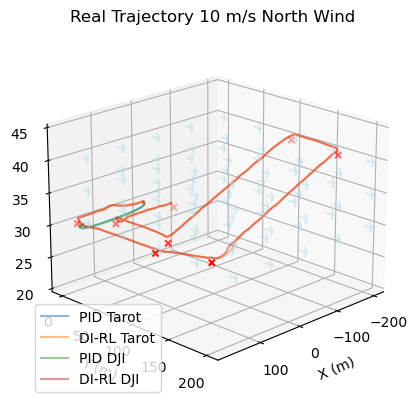

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Real Trajectory 10 m/s North Wind")
ax.plot(logs[0].x, logs[0].y, logs[0].z, label='PID Tarot', alpha=0.5) # PID tarot
ax.plot(logs[1].x, logs[1].y, logs[1].z, label='DI-RL Tarot', alpha=0.5) # PID DJI
ax.plot(logs[2].x, logs[2].y, logs[2].z, label='PID DJI', alpha=0.5) # DI-RL Tarot
ax.plot(logs[3].x, logs[3].y, logs[3].z, label='DI-RL DJI', alpha=0.5) # DI-RL DJI
ax.scatter(nasa_wp[:, 0], nasa_wp[:, 1], nasa_wp[:, 2], marker='x', color="red")

# Create a grid of points to represent the wind field
x_range = np.linspace(-200, 150, 5)  # Adjust the number of points as needed
y_range = np.linspace(0, 200, 5)  # Adjust the number of points as needed
z_range = np.linspace(30, 40, 3)  # Adjust the z-range as needed

# Create a grid of points using meshgrid
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Define wind vectors at each grid point
U = np.zeros_like(X)  # Adjust the wind components as needed
V = np.ones_like(Y)
W = np.zeros_like(Z)

# Plot the wind vectors
ax.quiver(X, Y, Z, U, V, W, color='lightblue', alpha=0.4,length=10)

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_zlim(20, 45)
ax.view_init(20, 45)
plt.savefig('./figures/n_nasa.png')
plt.show()


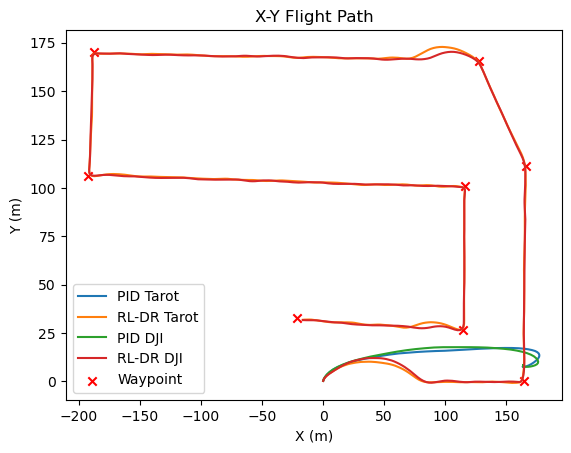

In [12]:
plt.title("X-Y Flight Path")

plt.plot(logs[0].x, logs[0].y, label='PID Tarot')
plt.plot(logs[1].x, logs[1].y, label='RL-DR Tarot')
plt.plot(logs[2].x, logs[2].y, label='PID DJI')
plt.plot(logs[3].x, logs[3].y, label='RL-DR DJI')
plt.scatter(nasa_wp[:, 0], nasa_wp[:, 1], marker='x', color="red", label='Waypoint')

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()

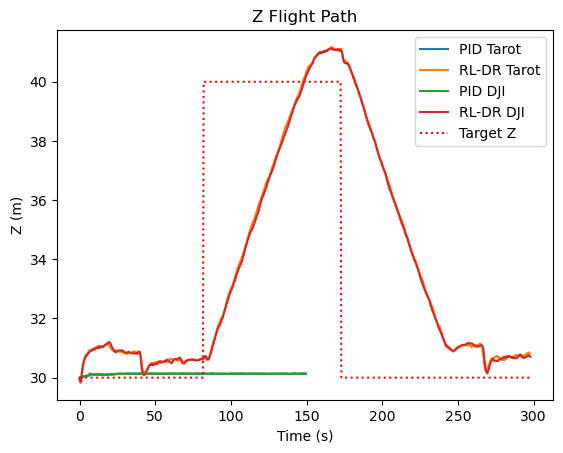

In [13]:
plt.title("Z Flight Path")
wps = np.array(wps)

plt.plot(np.arange(len(logs[0]))*0.5, logs[0].z, label='PID Tarot')
plt.plot(np.arange(len(logs[1]))*0.5, logs[1].z, label='RL-DR Tarot')
plt.plot(np.arange(len(logs[2]))*0.5, logs[2].z, label='PID DJI')
plt.plot(np.arange(len(logs[3]))*0.5, logs[3].z, label='RL-DR DJI')
plt.plot(np.arange(len(wps))*0.5, wps[:,2], color="red", label='Target Z', linestyle=':')

plt.xlabel("Time (s)")
plt.ylabel("Z (m)")
plt.legend()

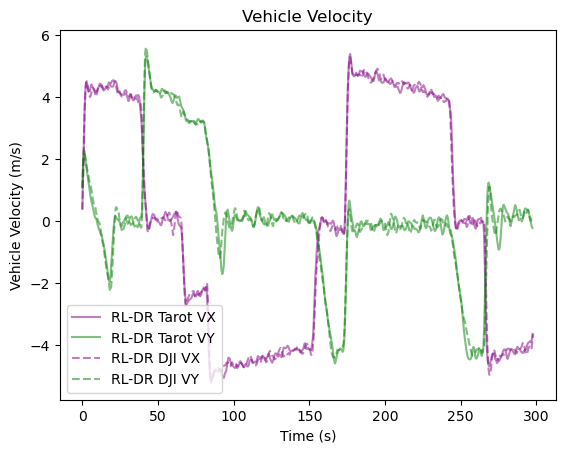

In [14]:
plt.title("Vehicle Velocity")
wps = np.array(wps)

# plt.plot(np.arange(len(logs[0]))*0.5, logs[0].velocity[:,0], label='PID Tarot')
plt.plot(np.arange(len(logs[1]))*0.5, logs[1].velocity[:,0], label='RL-DR Tarot VX', alpha=0.5, color='purple')
plt.plot(np.arange(len(logs[1]))*0.5, logs[1].velocity[:,1], label='RL-DR Tarot VY', alpha=0.5, color='green')
# plt.plot(np.arange(len(logs[2]))*0.5, logs[2].velocity[:,0], label='PID DJI')
plt.plot(np.arange(len(logs[3]))*0.5, logs[3].velocity[:,0], label='RL-DR DJI VX', linestyle='--', alpha=0.5, color='purple')
plt.plot(np.arange(len(logs[3]))*0.5, logs[3].velocity[:,1], label='RL-DR DJI VY', linestyle='--', alpha=0.5, color='green')

plt.xlabel("Time (s)")
plt.ylabel("Vehicle Velocity (m/s)")
plt.legend()

In [28]:
nasa_wp = np.asarray([ # initial (0,0,30), this is a triangle trajectory, same as flight 3
       [  0.8878366 ,  11.11141949,  31.6       ],
       [ 11.98579425,  91.11363985,  40.8       ],
       [ 23.08375209, 224.45067377,  55.2       ],
       [ 34.18171011, 322.2311653 ,  64.6       ],
       [ 60.03995303, 494.59150444,  81.4       ],
       [ 89.67150303, 464.45733478,  83.4       ],
       [200.65110295, 375.56597886,  89.7       ],
       [269.79140319, 315.38653089,  93.8       ],
       [477.21234758, 149.87082613,  97.        ],
       [  7.65759075, -37.51215221,  30.        ]
    ])

In [29]:
logs = evaluate_agents(all_agents, all_params, [(0,0), (-10,-10), (0,0)], env_types, uses_dji)

100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [01:01<00:00, 15.37s/it]


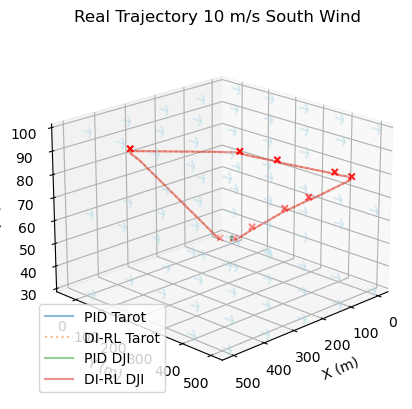

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Real Trajectory 10 m/s South Wind")
ax.plot(logs[0].x, logs[0].y, logs[0].z, label='PID Tarot', alpha=0.5) # PID tarot
ax.plot(logs[1].x, logs[1].y, logs[1].z, label='DI-RL Tarot', alpha=0.5, linestyle=':') # PID DJI
ax.plot(logs[2].x, logs[2].y, logs[2].z, label='PID DJI', alpha=0.5) # DI-RL Tarot
ax.plot(logs[3].x, logs[3].y, logs[3].z, label='DI-RL DJI', alpha=0.5) # DI-RL DJI
ax.scatter(nasa_wp[:, 0], nasa_wp[:, 1], nasa_wp[:, 2], marker='x', color="red")

# Create a grid of points to represent the wind field
x_range = np.linspace(0, 500, 5)  # Adjust the number of points as needed
y_range = np.linspace(0, 500, 5)  # Adjust the number of points as needed
z_range = np.linspace(30, 100, 3)  # Adjust the z-range as needed

# Create a grid of points using meshgrid
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Define wind vectors at each grid point
U = np.zeros_like(X)  # Adjust the wind components as needed
V = np.ones_like(Y)
W = np.zeros_like(Z)

# Plot the wind vectors
ax.quiver(X, Y, Z, U, V, W, color='lightblue', alpha=0.4,length=30)

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_zlim(30, 100)
ax.view_init(20, 45)
# plt.savefig('./figures/n_nasa.png')
plt.show()


In [13]:
np.linspace(min(logs[3].x), max(logs[3].x))

array([5.21249995e-02, 3.34980434e+00, 6.64748367e+00, 9.94516301e+00,
       1.32428423e+01, 1.65405217e+01, 1.98382010e+01, 2.31358804e+01,
       2.64335597e+01, 2.97312390e+01, 3.30289184e+01, 3.63265977e+01,
       3.96242770e+01, 4.29219564e+01, 4.62196357e+01, 4.95173150e+01,
       5.28149944e+01, 5.61126737e+01, 5.94103531e+01, 6.27080324e+01,
       6.60057117e+01, 6.93033911e+01, 7.26010704e+01, 7.58987497e+01,
       7.91964291e+01, 8.24941084e+01, 8.57917877e+01, 8.90894671e+01,
       9.23871464e+01, 9.56848258e+01, 9.89825051e+01, 1.02280184e+02,
       1.05577864e+02, 1.08875543e+02, 1.12173222e+02, 1.15470902e+02,
       1.18768581e+02, 1.22066260e+02, 1.25363940e+02, 1.28661619e+02,
       1.31959298e+02, 1.35256978e+02, 1.38554657e+02, 1.41852336e+02,
       1.45150016e+02, 1.48447695e+02, 1.51745374e+02, 1.55043054e+02,
       1.58340733e+02, 1.61638412e+02])